In this notebook, we'll learn how to use GANs to do semi-supervised learning.

In supervised learning, we have a training set of inputs $x$ and class labels $y$. We train a model that takes $x$ as input and gives $y$ as output.

In semi-supervised learning, our goal is still to train a model that takes $x$ as input and generates $y$ as output. However, not all of our training examples have a label $y$. We need to develop an algorithm that is able to get better at classification by studying both labeled $(x, y)$ pairs and unlabeled $x$ examples.

To do this for the SVHN dataset, we'll turn the GAN discriminator into an 11 class discriminator. It will recognize the 10 different classes of real SVHN digits, as well as an 11th class of fake images that come from the generator. The discriminator will get to train on real labeled images, real unlabeled images, and fake images. By drawing on three sources of data instead of just one, it will generalize to the test set much better than a traditional classifier trained on only one source of data.

In [2]:
%matplotlib inline

import pickle as pkl
import time

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf


In [3]:
!mkdir data

Ya existe el subdirectorio o el archivo data.


In [4]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

In [5]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

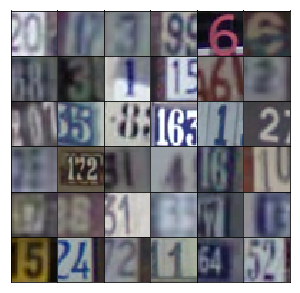

In [6]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

In [7]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [9]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=True, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        # The SVHN dataset comes with lots of labels, but for the purpose of this exercise,
        # we will pretend that there are only 1000.
        # We use this mask to say which labels we will allow ourselves to use.
        self.label_mask = np.zeros_like(self.train_y)
        self.label_mask[0:1000] = 1
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.train_x = self.scaler(self.train_x)
        self.valid_x = self.scaler(self.valid_x)
        self.test_x = self.scaler(self.test_x)
        self.shuffle = shuffle
        
    def batches(self, batch_size, which_set="train"):
        x_name = which_set + "_x"
        y_name = which_set + "_y"
        
        num_examples = len(getattr(dataset, y_name))
        if self.shuffle:
            idx = np.arange(num_examples)
            np.random.shuffle(idx)
            setattr(dataset, x_name, getattr(dataset, x_name)[idx])
            setattr(dataset, y_name, getattr(dataset, y_name)[idx])
            if which_set == "train":
                dataset.label_mask = dataset.label_mask[idx]
        
        dataset_x = getattr(dataset, x_name)
        dataset_y = getattr(dataset, y_name)
        for ii in range(0, num_examples, batch_size):
            x = dataset_x[ii:ii+batch_size]
            y = dataset_y[ii:ii+batch_size]
            
            if which_set == "train":
                # When we use the data for training, we need to include
                # the label mask, so we can pretend we don't have access
                # to some of the labels, as an exercise of our semi-supervised
                # learning ability
                yield x, y, self.label_mask[ii:ii+batch_size]
            else:
                yield x, y

In [10]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    y = tf.placeholder(tf.int32, (None), name='y')
    label_mask = tf.placeholder(tf.int32, (None), name='label_mask')
    
    return inputs_real, inputs_z, y, label_mask

In [11]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True, size_mult=128):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4 * 4 * size_mult * 4)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, size_mult * 4))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, size_mult * 2, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, size_mult, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, output_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        return out

In [12]:
def discriminator(x, reuse=False, alpha=0.2, drop_rate=0., num_classes=10, size_mult=64):
    with tf.variable_scope('discriminator', reuse=reuse):
        x = tf.layers.dropout(x, rate=drop_rate/2.5)
        
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(x, size_mult, 3, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        relu1 = tf.layers.dropout(relu1, rate=drop_rate)
        
        x2 = tf.layers.conv2d(relu1, size_mult, 3, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * x2, x2)
        
        
        x3 = tf.layers.conv2d(relu2, size_mult, 3, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.layers.dropout(relu3, rate=drop_rate)
        
        x4 = tf.layers.conv2d(relu3, 2 * size_mult, 3, strides=1, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        
        x5 = tf.layers.conv2d(relu4, 2 * size_mult, 3, strides=1, padding='same')
        bn5 = tf.layers.batch_normalization(x5, training=True)
        relu5 = tf.maximum(alpha * bn5, bn5)
        
        x6 = tf.layers.conv2d(relu5, 2 * size_mult, 3, strides=2, padding='same')
        bn6 = tf.layers.batch_normalization(x6, training=True)
        relu6 = tf.maximum(alpha * bn6, bn6)
        relu6 = tf.layers.dropout(relu6, rate=drop_rate)
        
        x7 = tf.layers.conv2d(relu5, 2 * size_mult, 3, strides=1, padding='valid')
        # Don't use bn on this layer, because bn would set the mean of each feature
        # to the bn mu parameter.
        # This layer is used for the feature matching loss, which only works if
        # the means can be different when the discriminator is run on the data than
        # when the discriminator is run on the generator samples.
        relu7 = tf.maximum(alpha * x7, x7)
        
        # Flatten it by global average pooling
        features = tf.reduce_mean(relu7, (1, 2))
        
        # Set class_logits to be the inputs to a softmax distribution over the different classes
        class_logits = tf.layers.dense(features, num_classes)
        
        
        # Set gan_logits such that P(input is real | input) = sigmoid(gan_logits).
        # Keep in mind that class_logits gives you the probability distribution over all the real
        # classes and the fake class. You need to work out how to transform this multiclass softmax
        # distribution into a binary real-vs-fake decision that can be described with a sigmoid.
        # Numerical stability is very important.
        # You'll probably need to use this numerical stability trick:
        # log sum_i exp a_i = m + log sum_i exp(a_i - m).
        # This is numerically stable when m = max_i a_i.
        # (It helps to think about what goes wrong when...
        #   1. One value of a_i is very large
        #   2. All the values of a_i are very negative
        # This trick and this value of m fix both those cases, but the naive implementation and
        # other values of m encounter various problems)
        real_class_logits = class_logits
        fake_class_logits = 0.

        mx = tf.reduce_max(real_class_logits, 1, keep_dims=True)
        stable_real_class_logits = real_class_logits - mx

        gan_logits = tf.log(tf.reduce_sum(tf.exp(stable_real_class_logits), 1)) + tf.squeeze(mx) - fake_class_logits
        
        out = tf.nn.softmax(class_logits)
        
        return out, class_logits, gan_logits, features

In [20]:
def model_loss(input_real, input_z, output_dim, y, num_classes, label_mask, alpha=0.2, drop_rate=0.):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param output_dim: The number of channels in the output image
    :param y: Integer class labels
    :param num_classes: The number of classes
    :param alpha: The slope of the left half of leaky ReLU activation
    :param drop_rate: The probability of dropping a hidden unit
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    
    # These numbers multiply the size of each layer of the generator and the discriminator,
    # respectively. You can reduce them to run your code faster for debugging purposes.
    g_size_mult = 32
    d_size_mult = 64
    
    # Here we run the generator and the discriminator
    g_model = generator(input_z, output_dim, alpha=alpha, size_mult=g_size_mult)
    d_on_data = discriminator(input_real, alpha=alpha, drop_rate=drop_rate, size_mult=d_size_mult)
    d_model_real, class_logits_on_data, gan_logits_on_data, data_features = d_on_data
    d_on_samples = discriminator(g_model, reuse=True, alpha=alpha, drop_rate=drop_rate, size_mult=d_size_mult)
    d_model_fake, class_logits_on_samples, gan_logits_on_samples, sample_features = d_on_samples
    
    
    # Here we compute `d_loss`, the loss for the discriminator.
    # This should combine two different losses:
    #  1. The loss for the GAN problem, where we minimize the cross-entropy for the binary
    #     real-vs-fake classification problem.
    #  2. The loss for the SVHN digit classification problem, where we minimize the cross-entropy
    #     for the multi-class softmax. For this one we use the labels. Don't forget to ignore
    #     use `label_mask` to ignore the examples that we are pretending are unlabeled for the
    #     semi-supervised learning problem.
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=gan_logits_on_data,
                                                labels=tf.ones_like(gan_logits_on_data)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=gan_logits_on_samples,
                                                labels=tf.zeros_like(gan_logits_on_samples)))
    y = tf.squeeze(y)
    class_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=class_logits_on_data,
                                                                  labels=tf.one_hot(y, num_classes,
                                                                                    dtype=tf.float32))
    class_cross_entropy = tf.squeeze(class_cross_entropy)
    label_mask = tf.squeeze(tf.to_float(label_mask))
    d_loss_class = tf.reduce_sum(label_mask * class_cross_entropy) / tf.maximum(1., tf.reduce_sum(label_mask))
    d_loss = d_loss_class + d_loss_real + d_loss_fake
    
    # Here we set `g_loss` to the "feature matching" loss invented by Tim Salimans at OpenAI.
    # This loss consists of minimizing the absolute difference between the expected features
    # on the data and the expected features on the generated samples.
    # This loss works better for semi-supervised learning than the tradition GAN losses.
    data_moments = tf.reduce_mean(data_features, axis=0)
    sample_moments = tf.reduce_mean(sample_features, axis=0)
    g_loss = tf.reduce_mean(tf.abs(data_moments - sample_moments))

    pred_class = tf.cast(tf.argmax(class_logits_on_data, 1), tf.int32)
    eq = tf.equal(tf.squeeze(y), pred_class)
    correct = tf.reduce_sum(tf.to_float(eq))
    masked_correct = tf.reduce_sum(label_mask * tf.to_float(eq))
    
    return d_loss, g_loss, correct, masked_correct, g_model

In [15]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and biases to update. Get them separately for the discriminator and the generator
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    for t in t_vars:
        assert t in d_vars or t in g_vars

    # Minimize both players' costs simultaneously
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    shrink_lr = tf.assign(learning_rate, learning_rate * 0.9)
    
    return d_train_opt, g_train_opt, shrink_lr

In [16]:
class GAN:
    """
    A GAN model.
    :param real_size: The shape of the real data.
    :param z_size: The number of entries in the z code vector.
    :param learnin_rate: The learning rate to use for Adam.
    :param num_classes: The number of classes to recognize.
    :param alpha: The slope of the left half of the leaky ReLU activation
    :param beta1: The beta1 parameter for Adam.
    """
    def __init__(self, real_size, z_size, learning_rate, num_classes=10, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.learning_rate = tf.Variable(learning_rate, trainable=False)
        inputs = model_inputs(real_size, z_size)
        self.input_real, self.input_z, self.y, self.label_mask = inputs
        self.drop_rate = tf.placeholder_with_default(.5, (), "drop_rate")
        
        loss_results = model_loss(self.input_real, self.input_z,
                                  real_size[2], self.y, num_classes,
                                  label_mask=self.label_mask,
                                  alpha=0.2,
                                  drop_rate=self.drop_rate)
        self.d_loss, self.g_loss, self.correct, self.masked_correct, self.samples = loss_results
        
        self.d_opt, self.g_opt, self.shrink_lr = model_opt(self.d_loss, self.g_loss, self.learning_rate, beta1)

In [24]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img)
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

In [17]:
def train(net, dataset, epochs, batch_size, figsize=(5,5)):
    
    saver = tf.train.Saver()
    sample_z = np.random.normal(0, 1, size=(50, z_size))

    samples, train_accuracies, test_accuracies = [], [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            print("Epoch",e)
            
            t1e = time.time()
            num_examples = 0
            num_correct = 0
            for x, y, label_mask in dataset.batches(batch_size):
                assert 'int' in str(y.dtype)
                steps += 1
                num_examples += label_mask.sum()

                # Sample random noise for G
                batch_z = np.random.normal(0, 1, size=(batch_size, z_size))

                # Run optimizers
                t1 = time.time()
                _, _, correct = sess.run([net.d_opt, net.g_opt, net.masked_correct],
                                         feed_dict={net.input_real: x, net.input_z: batch_z,
                                                    net.y : y, net.label_mask : label_mask})
                t2 = time.time()
                num_correct += correct

            sess.run([net.shrink_lr])
            
            
            train_accuracy = num_correct / float(num_examples)
            
            print("\t\tClassifier train accuracy: ", train_accuracy)
            
            num_examples = 0
            num_correct = 0
            for x, y in dataset.batches(batch_size, which_set="test"):
                assert 'int' in str(y.dtype)
                num_examples += x.shape[0]

                correct, = sess.run([net.correct], feed_dict={net.input_real: x,
                                                   net.y : y,
                                                   net.drop_rate: 0.})
                num_correct += correct
            
            test_accuracy = num_correct / float(num_examples)
            print("\t\tClassifier test accuracy", test_accuracy)
            print("\t\tStep time: ", t2 - t1)
            t2e = time.time()
            print("\t\tEpoch time: ", t2e - t1e)
            
            
            gen_samples = sess.run(
                                   net.samples,
                                   feed_dict={net.input_z: sample_z})
            samples.append(gen_samples)
            _ = view_samples(-1, samples, 5, 10, figsize=figsize)
            plt.show()
            
            
            # Save history of accuracies to view after training
            train_accuracies.append(train_accuracy)
            test_accuracies.append(test_accuracy)
            

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return train_accuracies, test_accuracies, samples

In [18]:
!mkdir checkpoints

In [21]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.0003

net = GAN(real_size, z_size, learning_rate)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



Epoch 0
		Classifier train accuracy:  0.161
		Classifier test accuracy 0.20044560540872772
		Step time:  1.2644448280334473
		Epoch time:  941.8939640522003


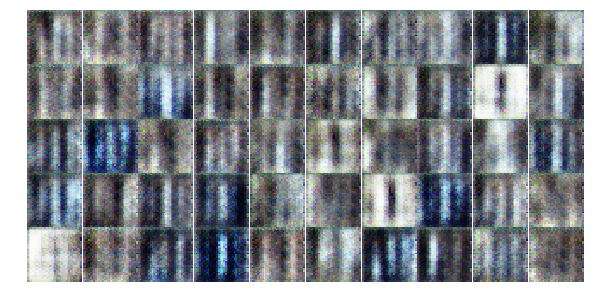

Epoch 1
		Classifier train accuracy:  0.228
		Classifier test accuracy 0.25138291333743085
		Step time:  1.2621824741363525
		Epoch time:  864.5112302303314


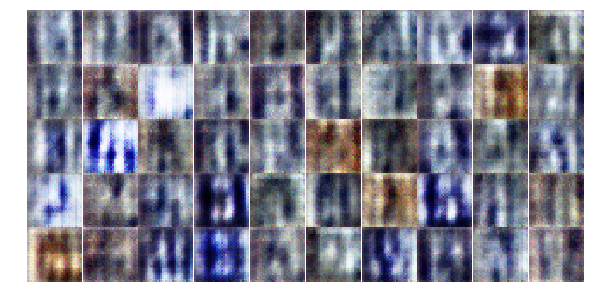

In [25]:
dataset = Dataset(trainset, testset)

batch_size = 128
epochs = 2 #25
train_accuracies, test_accuracies, samples = train(net,
                                                   dataset,
                                                   epochs,
                                                   batch_size,
                                                   figsize=(10,5))

In [ ]:
fig, ax = plt.subplots()
plt.plot(train_accuracies, label='Train', alpha=0.5)
plt.plot(test_accuracies, label='Test', alpha=0.5)
plt.title("Accuracy")
plt.legend()

When you run the fully implemented semi-supervised GAN, you should usually find that the test accuracy peaks at 69-71%. It should definitely stay above 68% fairly consistently throughout the last several epochs of training.

This is a little bit better than a [NIPS 2014 paper](https://arxiv.org/pdf/1406.5298.pdf) that got 64% accuracy on 1000-label SVHN with variational methods. However, we still have lost something by not using all the labels. If you re-run with all the labels included, you should obtain over 80% accuracy using this architecture (and other architectures that take longer to run can do much better).

In [ ]:
_ = view_samples(-1, samples, 5, 10, figsize=(10,5))

In [ ]:
!mkdir images

In [ ]:
for ii in range(len(samples)):
    fig, ax = view_samples(ii, samples, 5, 10, figsize=(10,5))
    fig.savefig('images/samples_{:03d}.png'.format(ii))
    plt.close()

Congratulations! You now know how to train a semi-supervised GAN. This exercise is stripped down to make it run faster and to make it simpler to implement. In the original work by Tim Salimans at OpenAI, a GAN using [more tricks and more runtime](https://arxiv.org/pdf/1606.03498.pdf) reaches over 94% accuracy using only 1,000 labeled examples.